2023-06-22 20:06:11.391140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

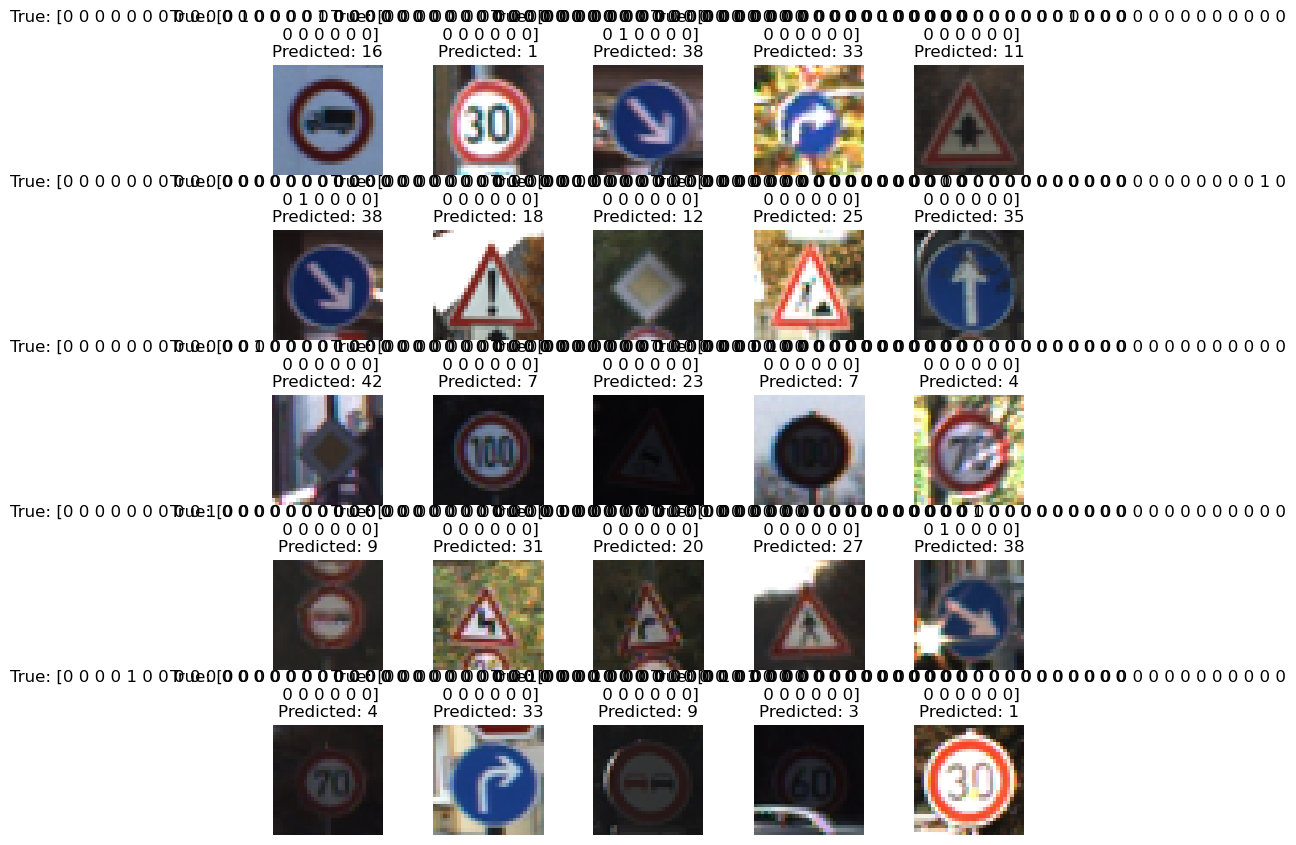

Confusion Matrix:
[[ 49   1   0 ...   0   0   0]
 [  0 707   8 ...   0   0   0]
 [  0   2 742 ...   1   0   0]
 ...
 [  0   0   1 ...  72   0   1]
 [  0   0   0 ...   0  55   3]
 [  0   0   0 ...   1   3  86]]


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Përcakto path-in e datasetit
dataset_path = 'gtsrb-dataset'

# Ngarko skedarët CSV
train_data = pd.read_csv(os.path.join(dataset_path, 'Train.csv'))
test_data = pd.read_csv(os.path.join(dataset_path, 'Test.csv'))
meta_data = pd.read_csv(os.path.join(dataset_path, 'Meta.csv'))

# Ngarko dhe përpuno imazhet e trajnimit
train_images = []
train_labels = []
for i, row in train_data.iterrows():
    image_path = os.path.join(dataset_path, row['Path'])
    image = Image.open(image_path)
    image = image.resize((32, 32))
    image_array = np.array(image)
    train_images.append(image_array)
    train_labels.append(row['ClassId'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Kryej one-hot encoding për etiketat e trajnimit
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)

# Ndaj imazhet e trajnimit në pjesën e trajnimit dhe pjesën e validimit
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=123)

# Ngarko dhe përpuno imazhet e testimit
test_images = []
test_labels = []
for i, row in test_data.iterrows():
    image_path = os.path.join(dataset_path, row['Path'])
    image = Image.open(image_path)
    image = image.resize((32, 32))
    image_array = np.array(image)
    test_images.append(image_array)
    test_labels.append(row['ClassId'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Krijo modelin e rrjetit konvolucional
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(43, activation='softmax')
])

# Kompilo modelin
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printo përmbledhjen e modelit
model.summary()

# Trajno modelin
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(valid_images, valid_labels))

# Konverto etiketat e testimit në formatin one-hot encoding
test_labels = label_binarizer.transform(test_labels)

# Vlerëso modelin në setin e testimit
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Bëj parashikime në imazhet e testimit
predictions = model.predict(test_images)

# Konverto parashikimet në etiketa të klasave
predicted_labels = np.argmax(predictions, axis=1)

# Shfaq imazhet e klasifikuara të testimit
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(test_images[i])
    axes[i].set_title(f"True: {test_labels[i]}\nPredicted: {predicted_labels[i]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Llogarit matricën e konfuzionit
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

print("Confusion Matrix:")
print(cm)
